In [1]:
from PySDM_examples.Hill_et_al_2023.alpha_settings_run import Settings, Simulation
from PySDM_examples.Hill_et_al_2023.cross_sections import *
from PySDM_examples.Shipway_and_Hill_2012.plot import plot
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d
import matplotlib.pyplot as plt
import numpy as np
from PySDM.backends import CPU

In [2]:
# Things to check before comparing results:
# Cloud droplet size starts at 2um like in the 2023 paper (the other Shipway + Hill folder starts at 1um)
# Nd, D_vol and sigma values are computed using only > cloud size
# However LWC and LWP contain unactivated liquid sizes.. hm this might go into D_vol too

In [3]:
common_params = {
    "n_sd_per_gridbox": 20,
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 1000 * si.hPa,
    "kappa": .9,
    "rho_times_w_1": 3 * si.kg / si.m**3,
    'save_spec_and_attr_times':np.linspace(0,3600,721),
}
# if 'CI' in os.environ:
#     common_params["t_max"] = 10 * common_params["dt"]
#     common_params["n_sd_per_gridbox"] = 16 

output = {}
settings = {}
simulation = {}

precips = (True, False)
alphas = (0,)
aerosol_concs = (50,150,300)

In [4]:
backend = CPU()
for precip in precips:
    for na in aerosol_concs:
        for alpha in alphas:
            key = f"na={na}p={precip}_alpha={alpha}"
            settings[key] = Settings(
                **common_params,
                particles_per_volume_STP=na * si.cm**-3,
                precip=precip,
                alpha=alpha
            )
            simulation[key] = Simulation(settings[key], backend=backend)
            output[key] = simulation[key].run().products

/Users/emmaware/PySDM/PySDM/backends/numba.py:48: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


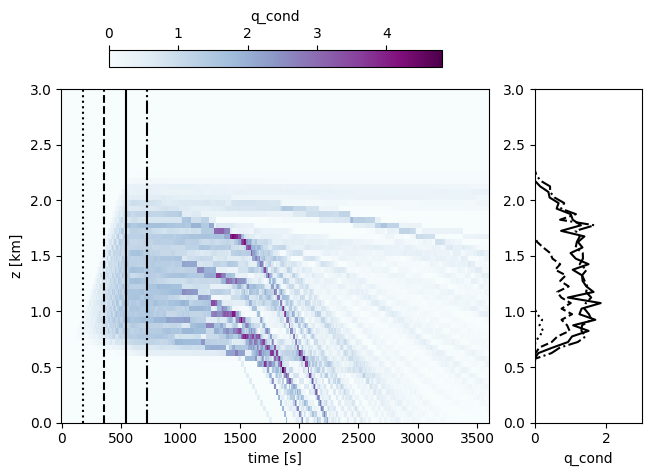

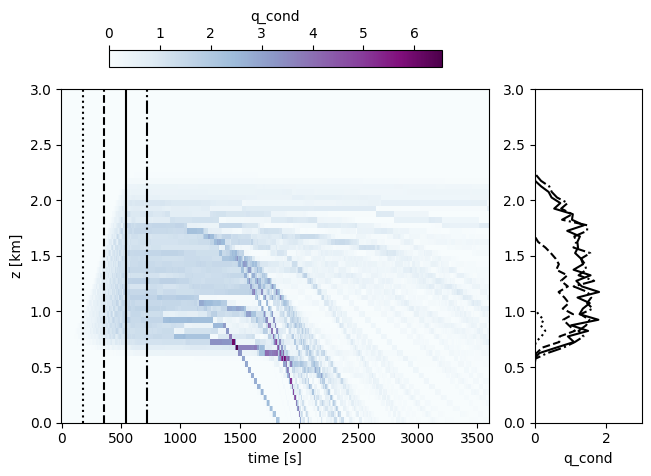

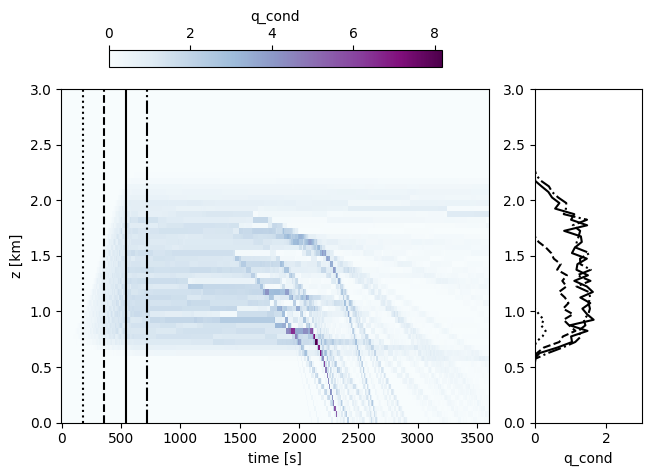

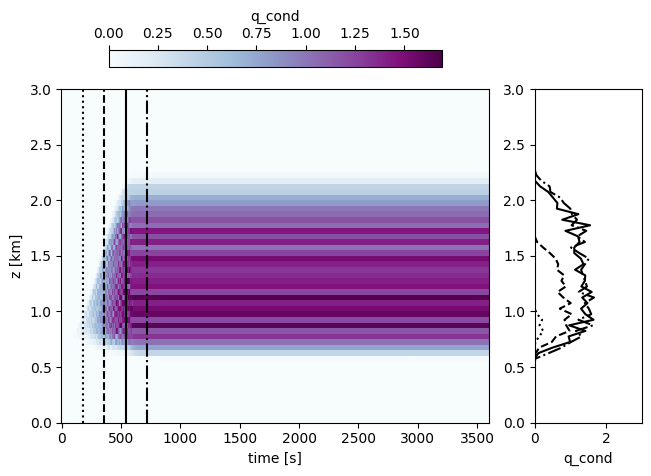

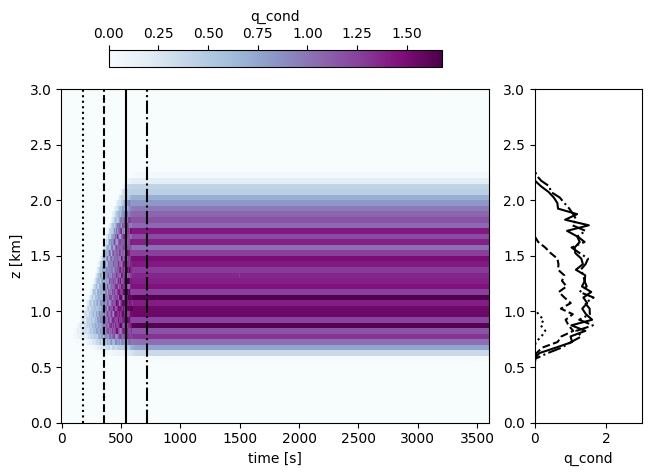

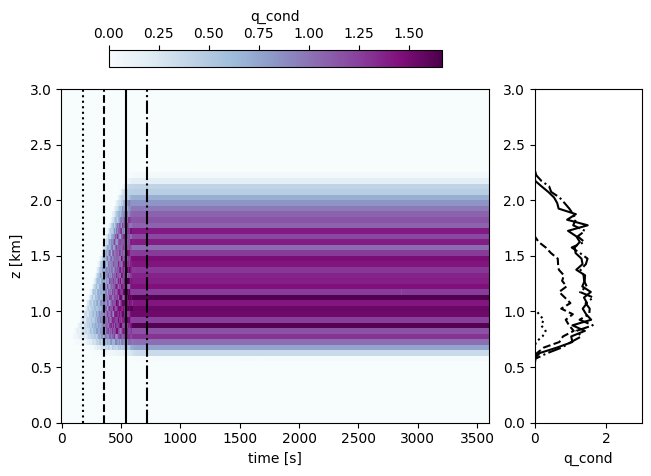

In [5]:
for precip in precips:
    for na in aerosol_concs:
        for alpha in alphas:
            key = f"na={na}p={precip}_alpha={alpha}"
            output[key]["q_cond"] = output[key]["cloud water mixing ratio"] + output[key]["rain water mixing ratio"]
line = {3: ':', 6: '--', 9: '-', 12: '-.'}
for p in precips:
    for na in aerosol_concs:
        for alpha in alphas:
            key = f"na={na}p={p}_alpha={alpha}"
            plot(var='q_cond', qlabel='q_cond', fname=f'{key}.pdf',
                output=output[key],line=line,ax2_xlims=(0,3))

In [6]:
above_ground = np.where(output[key]["z"] > 0)[0]
cloud_base = np.where(output[key]["z"] == 675)[0][0]
mosaic_row = lambda name: [f"{name}_{na}" for na in aerosol_concs]

def plot_mosaic(ax, data, label, unit,logy=False,logx=False,type='time'):
    if type == 'time':
        ax.plot(output[key]["t"]*si.s, data)
        ax.set_ylabel(label + f' [{unit}]')
        ax.set_xlabel('time [s]')
    else:
        ax.plot(data, output[key]["z"][above_ground] / si.km)
        ax.set_xlabel(label + f' [{unit}]')
        ax.set_ylabel('height [km]')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')

/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:50: RuntimeWarning: Mean of empty slice
  mean_num_conc[mean_num_conc == np.nan] = 0
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:9: RuntimeWarning: divide by zero encountered in divide
  


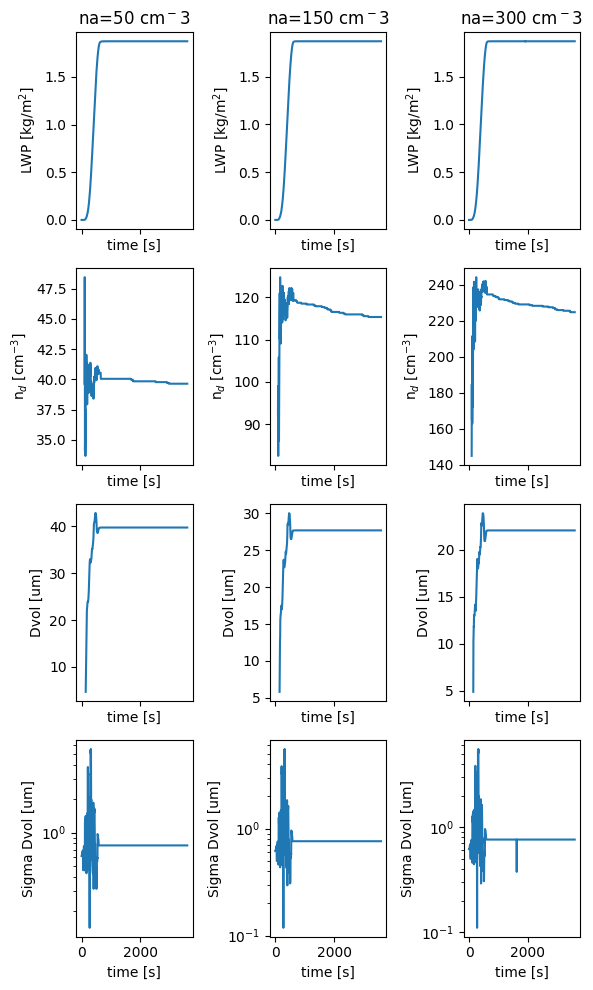

In [7]:
#fig_1: time series no precip
time_mosaic = [
    mosaic_row("LWP"),
    mosaic_row("nc"),
    mosaic_row("Dvol"),
    mosaic_row("sigma"),
]

fig, axes = plt.subplot_mosaic(time_mosaic, figsize=(6, 10),sharex=True, tight_layout=True)

for na in aerosol_concs:
    for alpha in alphas:
        key = f"na={na}p=False_alpha={alpha}"
    
        LWP, mean_num_conc = compute_LWP_and_nc_time_series(output[key],settings[key], above_ground)
        mean_num_conc = mean_num_conc / si.cm**-3

        # Computed at max LWC height? the other plot is at cloud base, ~700 m (675 m here bc of indexing)
        max_LWC_height = np.where(output[key]["LWC"] == np.max(output[key]["LWC"]))[0][0]
        D_vol, sigma = compute_dvol_andsigma_time_series(output[key],settings[key], max_LWC_height)
        D_vol = D_vol / si.um
        sigma = sigma / si.um

        plot_mosaic(axes[f"LWP_{na}"], LWP, "LWP", "kg/m$^2$")
        plot_mosaic(axes[f"nc_{na}"], mean_num_conc, "n$_d$", "cm$^{-3}$")
        plot_mosaic(axes[f"Dvol_{na}"], D_vol, "Dvol", "um")
        plot_mosaic(axes[f"sigma_{na}"], sigma, "Sigma Dvol", "um", logy=True)

        axes[f"LWP_{na}"].set_title(f"na={na} cm$ ^{-3}$")


/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:28: RuntimeWarning: divide by zero encountered in divide
  
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:28: RuntimeWarning: invalid value encountered in divide
  
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:36: RuntimeWarning: invalid value encountered in divide
  Nd = np.sum(nc, axis=1)


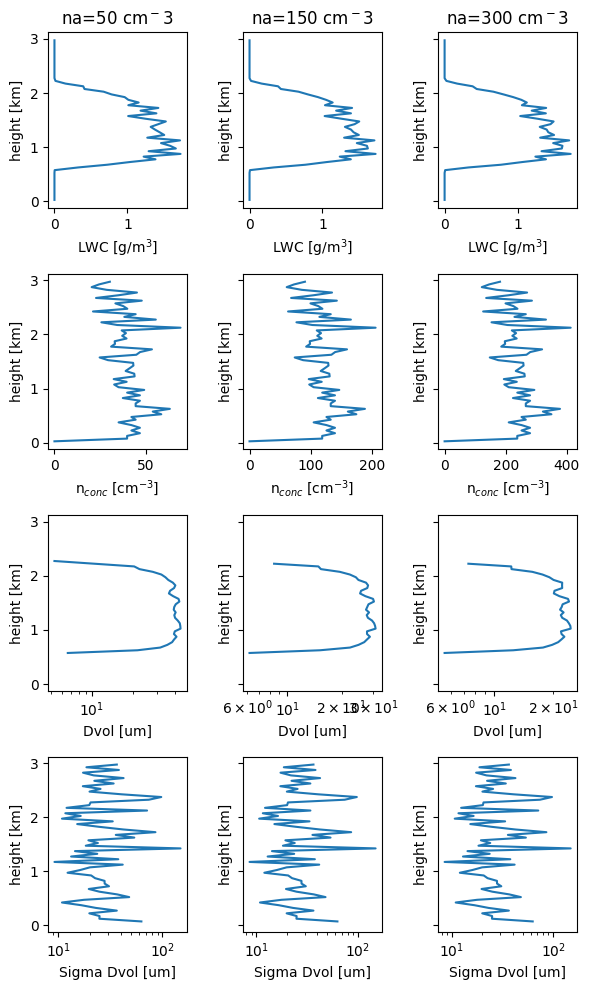

In [8]:
#fig_2: vertical profiles no precip
t_slice = 600 * si.s 
vertical_mosaic = [
    mosaic_row("LWC"),
    mosaic_row("nc"),
    mosaic_row("Dvol"),
    mosaic_row("sigma"),
]
fig, axes = plt.subplot_mosaic(vertical_mosaic, figsize=(6, 10),sharey=True,tight_layout=True)

for na in aerosol_concs:
    for alpha in alphas:
        key = f"na={na}p=False_alpha={alpha}"

        LWC,num_conc_vertical = compute_LWP_and_nc_vertical(output[key], above_ground, t_slice)
        LWC = LWC / si.g # kg ->g
        num_conc_vertical = num_conc_vertical / si.cm**-3
        D_vol_vertical, sigma_vertical = compute_dvol_andsigma_vertical(output[key],settings[key], above_ground, t_slice)
        D_vol_vertical = D_vol_vertical / si.um
        sigma_vertical = sigma_vertical / si.um
        plot_mosaic(axes[f"LWC_{na}"], LWC, "LWC", "g/m$^3$", type='vertical')
        plot_mosaic(axes[f"nc_{na}"], num_conc_vertical, "n$_{conc}$", "cm$^{-3}$", type='vertical')
        plot_mosaic(axes[f"Dvol_{na}"], D_vol_vertical, "Dvol", "um", logx=True, type='vertical')
        plot_mosaic(axes[f"sigma_{na}"], sigma_vertical, "Sigma Dvol", "um", logx=True, type='vertical')

        axes[f"LWC_{na}"].set_title(f"na={na} cm$ ^{-3}$")


/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:9: RuntimeWarning: invalid value encountered in divide
  
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:18: RuntimeWarning: invalid value encountered in divide
  Nd = np.sum(nc)


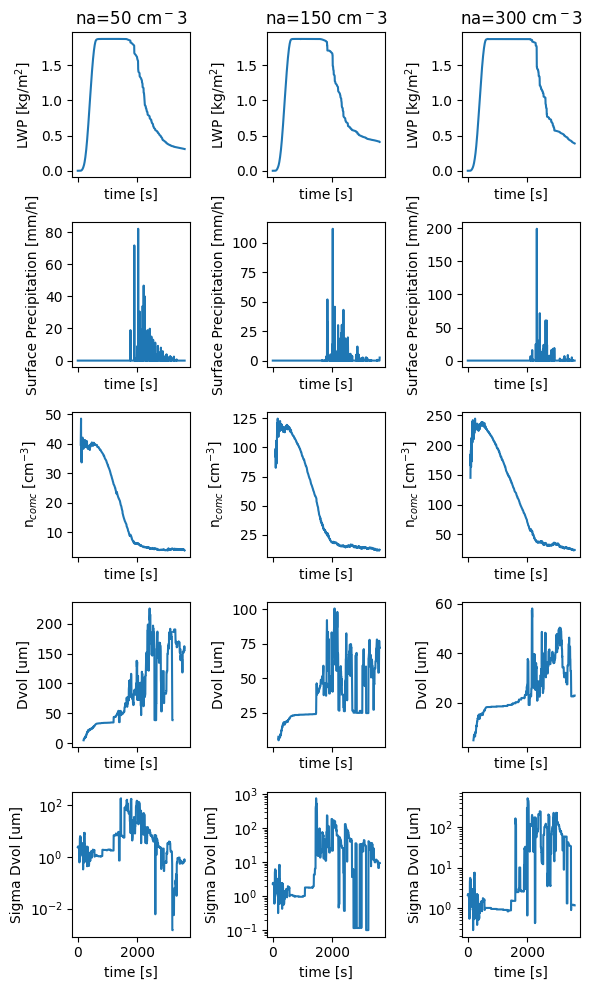

In [9]:
#fig_4: time series precip
time_mosaic = [
    mosaic_row("LWP"),
    mosaic_row("surface_precip"),
    mosaic_row("nc"),
    mosaic_row("Dvol"),
    mosaic_row("sigma"),
]
fig, axes = plt.subplot_mosaic(time_mosaic, figsize=(6, 10),sharex=True,tight_layout=True)

for na in aerosol_concs:
    for alpha in alphas:
        key = f"na={na}p=True_alpha={alpha}"
    
        LWP, mean_num_conc = compute_LWP_and_nc_time_series(output[key],settings[key], above_ground)
        mean_num_conc = mean_num_conc / si.cm**-3

        surface_precip = output[key]['surface precipitation']* si.hour/si.mm
        D_vol, sigma = compute_dvol_andsigma_time_series(output[key],settings[key], cloud_base)
        D_vol = D_vol / si.um
        sigma = sigma / si.um

        plot_mosaic(axes[f"LWP_{na}"], LWP, "LWP", "kg/m$^2$")
        plot_mosaic(axes[f"surface_precip_{na}"], surface_precip, "Surface Precipitation", "mm/h")
        plot_mosaic(axes[f"nc_{na}"], mean_num_conc, "n$_{comc}$", "cm$^{-3}$")
        plot_mosaic(axes[f"Dvol_{na}"], D_vol, "Dvol", "um",)
        plot_mosaic(axes[f"sigma_{na}"], sigma, "Sigma Dvol", "um", logy=True)


        axes[f"LWP_{na}"].set_title(f"na={na} cm$ ^{-3}$")